# Surrogate Construction for Genz Functions with regression as a function of the number of training points

This notebook constructs a PC surrogate for Genz functions using random sampling and regression, giving the RMS error bewteen the surrogate and the actual function. Both the Genz function and PCE are defined on [-1,1].

In [1]:
# imports
import numpy as np
import math  
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import qmc

import PyUQTk.pce as uqtkpce
import PyUQTk.PyPCE.pce_tools as pce_tools
from PyUQTk.utils.func import *
import PyUQTk.uqtkarray as uqtkarray

PyMC is required for some of the MCMC postprocessing codes.
Will proceed without, but some convergence tests will not be available.


## Inputs

In [2]:
nord = 3           # Order of the PCE
pc_type = "LU"     # Polynomial type
pc_alpha = 0.0     # Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs
pc_beta = 1.0      # Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs
nSam = 10000       # Number of evaluation samples samples
max_dim=6          # Maximum number of dimensions to include
model= 'genz_osc'  # Choices are 'genz_osc', 'genz_exp', 'genz_cont','genz_gaus','genz_cpeak', 'genz_ppeak'

First, we define the random number generator.

## Collecting Errors

We loop through different numbers of random samples to feed into regression and obtain the RMSE. We start with a number of samples equal to 90% of the basis terms and continue to 125%.

In [3]:
sigma = np.array([1.e-08]) # inital noise variance; updated in BCS
eta = 1e-3                 # threshold for stopping the algorithm
lambda_init = np.array([]) # set lambda to a fixed nonnegative value

scale = 0.1     # diagonal loading parameter
adaptive = 1    # generative basis for adaptive CS, 0 or 1
optimal = 1     # use the rigorous implementation of adaptive CS, 0 or 1

In [4]:
percent=[.6, .65, .7, .75, .8, .85, .9, .95, 1, 1.05, 1.10, 1.15, 1.2, 1.25] # fractions of the number of basis terms to use

# arrays to store error statistics for each dimension
mean_dim_errors=np.zeros((max_dim, len(percent)))
std_dim_errors=np.zeros((max_dim, len(percent)))

terms=np.zeros((max_dim, len(percent)))
nonz=[]

# loop through each dimension
for ndim in range(1, max_dim+1):
    print("ndim", ndim)
    # instantiate random generator
    rng = qmc.LatinHypercube(d=ndim, seed=42)
    
    # instantiate PC object
    pc_model = uqtkpce.PCSet("NISPnoq", nord, ndim,pc_type, pc_alpha,pc_beta)
    npce=pc_model.GetNumberPCTerms()
    terms[ndim-1]=npce
    
    # list to store stats for each percent
    mean_per_errors=[]
    std_per_errors=[]

    for per in percent:
        nTest=int(npce*per)
    
        # list to store stats for the 10 trials
        RMSE_list=[]
        
        for i in range(10):
            # train PC at random samples
            #rand=np.random.normal(loc=0, scale=0.5, size=(nTest, ndim))
            #rand=2*rng.random((int(nTest), ndim))-1
            rand=2*rng.random(n=nTest)-1
            f_evals=func(rand, model, np.ones(ndim+1))
            
            # find coefficients
            c_k = pce_tools.UQTkBCS(pc_model, f_evals, rand, sigma, eta, lambda_init, adaptive, optimal, scale)
            
            # evaluate at random samples
            #germ_samples=np.random.normal(0,0.5, (nSam,ndim))
            #germ_samples=2*rng.random((nSam, ndim))-1
            germ_samples=2*rng.random(n=nSam)-1
            pce_evals=pce_tools.UQTkEvaluatePCE(pc_model,c_k,germ_samples)
         
            # find error
            f_actual=func(germ_samples,model,np.ones(ndim+1))
            MSE = np.square(np.subtract(f_actual,pce_evals)).mean()
            RMSE=math.sqrt(MSE)
            RMSE_list.append(RMSE)
            
            
        # add the results of the 10 trials    
        mean_per_errors.append(np.array(RMSE_list).mean())
        std_per_errors.append(np.std(np.array(RMSE_list)))
        
    nonz.append(len(np.nonzero(c_k)[0]))

    mean_dim_errors[ndim-1]=mean_per_errors
    std_dim_errors[ndim-1]=std_per_errors

ndim 1
Iteration # 0
BCS algorithm converged, # iterations : 2 
Iteration # 0
BCS algorithm converged, # iterations : 2 
Iteration # 0
BCS algorithm converged, # iterations : 2 
Iteration # 0
BCS algorithm converged, # iterations : 2 
Iteration # 0
BCS algorithm converged, # iterations : 2 
Iteration # 0
BCS algorithm converged, # iterations : 2 
Iteration # 0
BCS algorithm converged, # iterations : 2 
Iteration # 0
BCS algorithm converged, # iterations : 2 
Iteration # 0
BCS algorithm converged, # iterations : 2 
Iteration # 0
BCS algorithm converged, # iterations : 2 
Iteration # 0
BCS algorithm converged, # iterations : 2 
Iteration # 0
BCS algorithm converged, # iterations : 2 
Iteration # 0
BCS algorithm converged, # iterations : 2 
Iteration # 0
BCS algorithm converged, # iterations : 2 
Iteration # 0
BCS algorithm converged, # iterations : 2 
Iteration # 0
BCS algorithm converged, # iterations : 2 
Iteration # 0
BCS algorithm converged, # iterations : 2 
Iteration # 0
BCS algori

In [5]:
len(np.nonzero(c_k)[0])

28

In [6]:
len(c_k)

84

## Summary
This table and figure display the error of each number of training points for each dimension. The number of training points varies as a percentage of the number of basis terms.

In [7]:
row_label=["dim "+str(i) for i in range(1, max_dim+1)]
pd.DataFrame(data=mean_dim_errors, index=row_label, columns=percent)

,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00,1.05,1.10,1.15,1.20,1.25
dim 1,0.285760,0.446043,0.407270,0.110077,0.098103,0.080247,0.263688,0.062496,0.000347,0.000342,0.000364,0.000293,0.000298,0.000330
dim 2,0.154183,0.276743,0.159773,0.146566,0.133515,0.079861,0.035396,0.037878,0.038055,0.036475,0.035525,0.024197,0.033208,0.027937
dim 3,0.153747,0.074958,0.100060,0.099613,0.037134,0.042888,0.042402,0.034774,0.098611,0.084577,0.034324,0.032377,0.034992,0.033399
dim 4,0.269598,0.223571,0.107564,0.136827,0.106110,0.104388,0.099120,0.105165,0.095719,0.101642,0.097515,0.102630,0.098653,0.088370
dim 5,0.290266,0.272711,0.251259,0.217592,0.189486,0.162552,0.164270,0.157004,0.152475,0.112055,0.151309,0.119215,0.098484,0.111591
dim 6,0.282790,0.267019,0.243370,0.186730,0.232449,0.210762,0.159124,0.136421,0.137392,0.085958,0.105113,0.094203,0.111652,0.100570


In [8]:
pd.DataFrame(data=terms, index=row_label, columns=percent)
np.transpose(terms)[0]

array([ 4., 10., 20., 35., 56., 84.])

In [9]:
nonz

[4, 8, 7, 13, 26, 28]

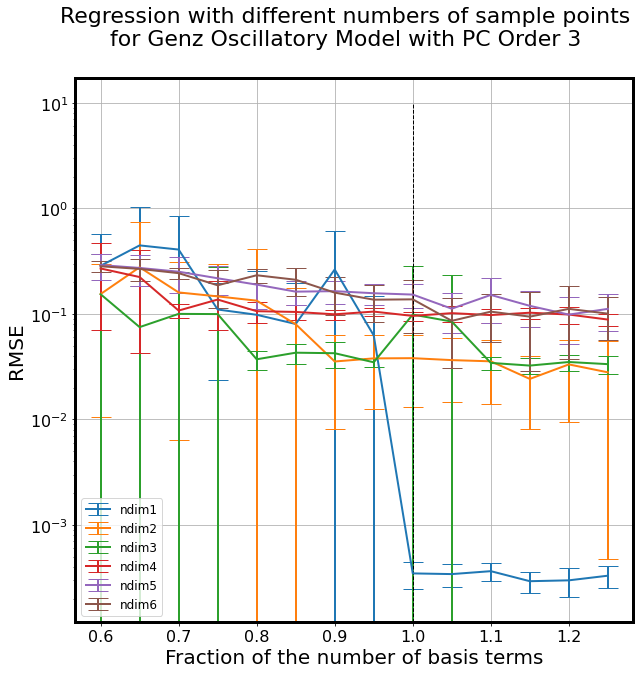

In [10]:
# Create figure
fig, ax = plt.subplots(figsize=(10,10))

# Plot Error Data
for ndim in range(1, max_dim +1):
    plt.errorbar(percent, mean_dim_errors[ndim-1], yerr=std_dim_errors[ndim-1], xerr=None, linewidth=2, markersize=8, capsize=10, label=str('ndim'+str(ndim)))

# Line where number of samples = number of basis terms
plt.vlines(x = 1, ymin = 0, ymax = 10, colors = 'black', linestyle="dashed")

# Label Axes
plt.xlabel("Fraction of the number of basis terms",fontsize=20)
plt.ylabel("RMSE",fontsize=20)

# Create legend
plt.legend(loc='lower left')

# Model titles to be displayed
if model=="genz_osc":
    model_title="Genz Oscillatory"
elif model=="genz_gaus":
    model_title="Genz Gaussian"
elif model=="genz_ppeak":
    model_title="Genz Product-Peak"
elif model=="genz_cpeak":
    model_title="Genz Corner-Peak"
elif model=="genz_exp":
    model_title="Genz Exponential"
else:
    model_title="Genz Continuous"

# Add title
fig.suptitle("Regression with different numbers of sample points\nfor %s Model with\
 PC Order %s"%(model_title, str(nord)), fontsize=22)

# Change y scale
plt.yscale('log')

#Change size of tick labels
plt.tick_params(axis='both', labelsize=16)

#Show figure
plt.show() 